In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import ipywidgets as ipw
from scipy.linalg import eigh

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def update_segs(ll,u):
    segs = ll.get_segments()
    for (ii,seg) in enumerate(segs):
        seg[1,1] = u[ii]
    ll.set_segments(segs)

# General solution of coupled harmonic oscillators

Solve coupled harmonic oscillator equations defined by (positive definite) matrices $M$ and $K$ where
\begin{equation}
M \frac{\mathrm{d}^2\vec{q}}{\mathrm{d}t^2} + K \vec{q} = 0
\end{equation}
We simultaneously diagonalize the matrices $M$ and $K$ such that $A^T M A = \mathbb{1}$ and $A^T K A = \Omega^2$, where $\Omega$ is a diagonal matrix with entries $(\omega_1, \omega_2, \omega_3, \ldots,)$ on the diagonal, and the columns of $A$ are the eigenvectors $\vec{A}_\alpha$, i.e.,
\begin{gather}
K \vec{A}_\alpha = \omega_\alpha^2 M \vec{A}_\alpha,
\end{gather}
We note that this also implies that $A^{-1} = A^T M$, such that $A A^T M = \mathbb{1}$ as well (we know the inverse $A^{-1}$ exists because the generalized eigenproblem for positive definite matrices of size $N\times N$ always has $N$ independent eigenvectors).

This leads to a system of uncoupled equations for the normal coordinates $Q_\alpha$, with $\vec q = A \vec Q \Leftrightarrow \vec Q = A^T M \vec q$. This can be obtained from the original equation by replacing $\vec q \to A \vec Q$ and multiplying by $A^T$ from the left.
\begin{equation}
\frac{\mathrm{d}^2\vec Q}{\mathrm{d}t^2} + \Omega^2 \vec Q = 0 \quad\Leftrightarrow\quad \frac{\mathrm{d}^2 Q_\alpha}{\mathrm{d}t^2} + \omega_\alpha^2 Q_\alpha = 0,
\end{equation}
with solutions $Q_\alpha(t) = \operatorname{Re}\left[c_\alpha e^{-i\omega_\alpha t}\right]$, where $c_\alpha$ is a complex constant. We can obtain these coefficients as $c_\alpha = \vec{A}_\alpha^T M \left(\vec{q}(0) + \frac{i}{\omega_\alpha} \dot{\vec{q}}(0)\right)$.

Two side remarks:

1. if the original problem had been driven, $M \frac{\mathrm{d}^2\vec{q}}{\mathrm{d}t^2} + K \vec{q} = \vec f(t)$, the same procedure as above would lead to
\begin{equation}
\frac{\mathrm{d}^2\vec Q}{\mathrm{d}t^2} + \Omega^2 \vec Q = A^T \vec f(t) = \vec F(t) \quad\Leftrightarrow\quad \frac{\mathrm{d}^2 Q_\alpha}{\mathrm{d}t^2} + \omega_\alpha^2 Q_\alpha = F_\alpha(t)
\end{equation}
i.e., the normal modes are still independent, but driven by the forces transformed into the normal coordinate basis.

2. If there is damping, $M \frac{\mathrm{d}^2\vec{q}}{\mathrm{d}t^2} + C \frac{\mathrm{d}\vec{q}}{\mathrm{d}t} + K \vec{q} = \vec f(t)$, one would have to solve a [quadratic eigenvalue problem](https://en.wikipedia.org/wiki/Quadratic_eigenvalue_problem), but the procedure is otherwise equivalent.

In [3]:
class coupled_harmosc:
    def __init__(self,M,K):
        N = K.shape[0]
        ωssq, As = eigh(K,M)
        ωs = np.sqrt(ωssq)
        assert np.allclose(As.T @ M @ As,np.eye(N))
        self.K = K
        self.M = M
        self.ωs = ωs
        self.As = As
    def solve(self,q0,v0,t):
        # q(t) = As (Rcs cos(ωs t) + Ics sin(ωs t))
        # v(t) = As ωs (-Rcs sin(ωs t) + Ics cos(ωs t))
        # q0 = As Rcs -> As^T M q0 = As^T M As Rcs = Rcs
        # v0 = As ωs Ics -> As^T M v0 = As^T M As ωs Ics = ωs Ics
        Rcs = self.As.T @ self.M @ q0
        Ics = (self.As.T @ self.M @ v0) / self.ωs
        self.cs = Rcs + 1j*Ics
        cst = self.cs[:,None]*np.exp(-1j*self.ωs[:,None]*t[None,:])
        self.Q = np.real(cst)
        self.V = self.ωs[:,None] * np.imag(cst)
        self.q = self.As @ self.Q
        self.v = self.As @ self.V
        self.t = t

## Two coupled oscillators

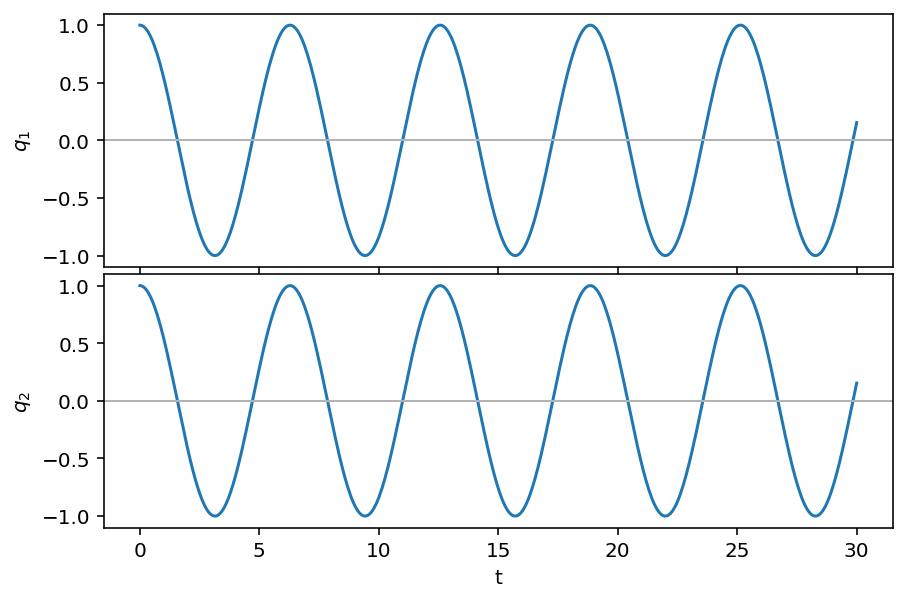

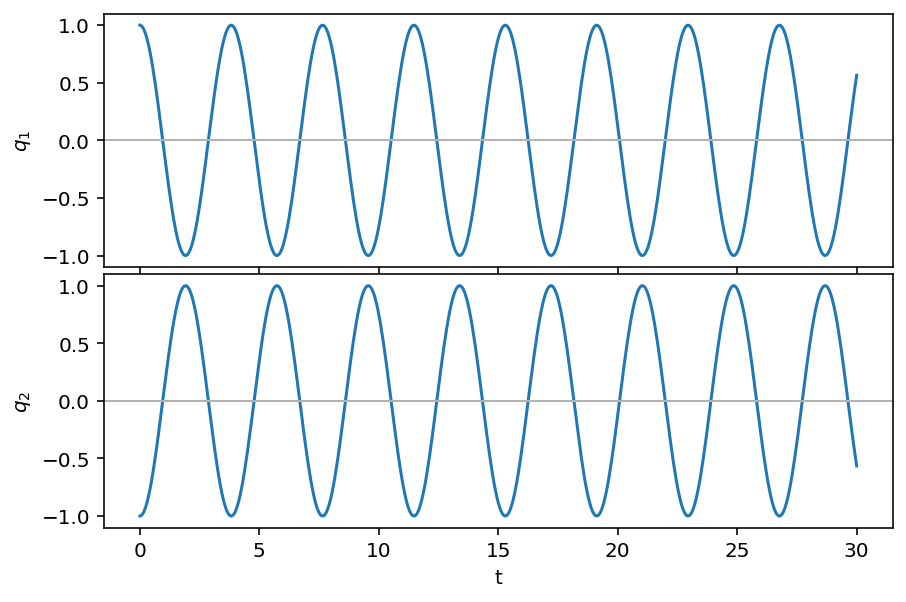

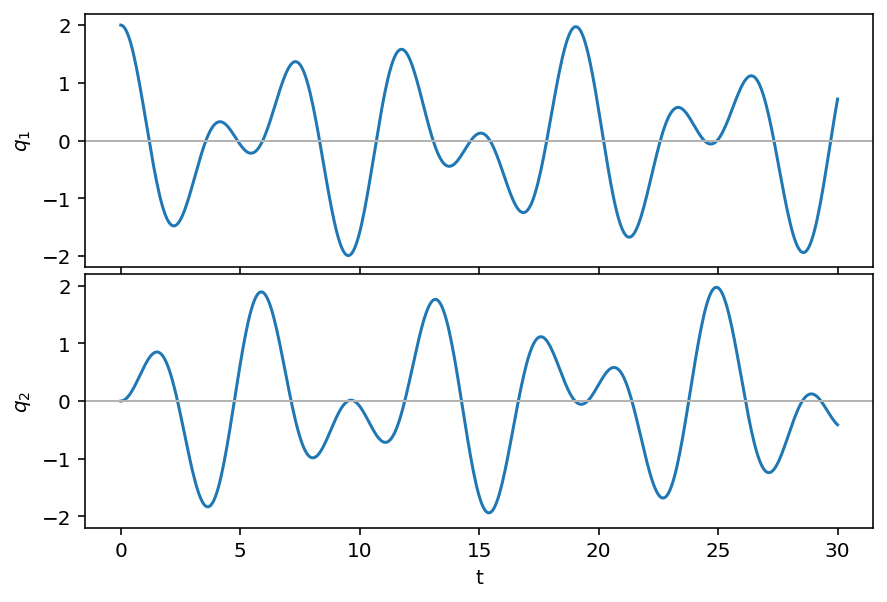

In [4]:
k = 1.
kp = 0.85
K = np.array([[k+kp,-kp],[-kp,k+kp]])
M = np.array([[1.,0.],[0.,1]])
ch = coupled_harmosc(M,K)

t = np.linspace(0,30,501)
v0 = [0.,0.]
for q0 in ([1.,1.], [1.,-1.], [2.,0]):
    ch.solve(q0,v0,t)
    f,axs = plt.subplots(2,1,sharex=True,sharey=True)
    for (ii,ax) in enumerate(axs):
        ax.plot(ch.t,ch.q[ii,:])
        ax.set_ylabel(f"$q_{ii+1}$")
        ax.axhline(0,lw=1,color="0.7")
    axs[1].set_xlabel("t")
    f.tight_layout(pad=0)

## Chain of coupled oscillators

In [5]:
N = 30
xs = np.linspace(-1,1,N)
ms = np.ones(N)
ωs = np.ones(N)
gs = (-.5 * ms * ωs**2)[1:]
M = np.diag(ms)
K = np.diag(ms*ωs**2)
K[range(1,N),range(N-1)] = K[range(N-1),range(1,N)] = gs
ch = coupled_harmosc(M,K)

In [6]:
q0 = np.exp(-xs**2/(2*0.15**2))
v0 = np.zeros_like(q0)
t = np.linspace(0.,200.,801)
ch.solve(q0,v0,t)

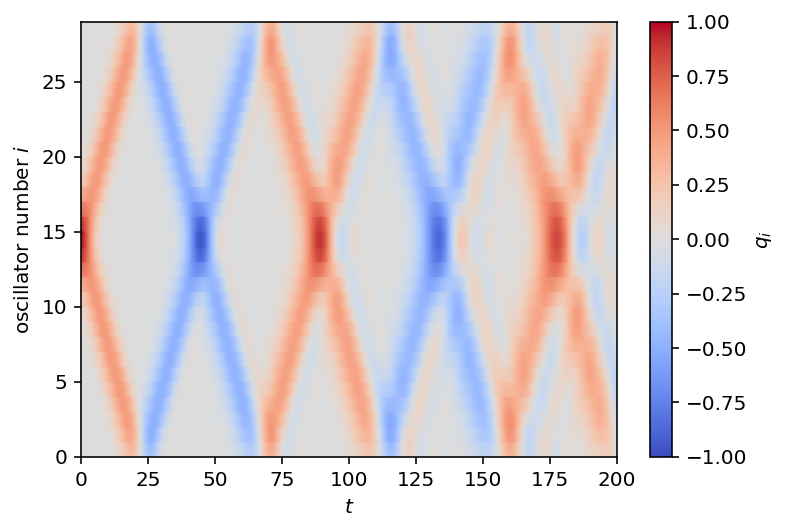

In [7]:
plt.pcolormesh(ch.t,range(N),ch.q,cmap="coolwarm",vmax=1,vmin=-1,shading='gouraud');
plt.xlabel("$t$")
plt.ylabel("oscillator number $i$")
cb = plt.colorbar()
cb.set_label("$q_i$");

In [8]:
# BUG: for the first use, %matplotlib widget has to be called twice
%matplotlib widget
%matplotlib widget

fig, ax = plt.subplots()
ln, = ax.plot(range(1,N+1), ch.q[:,0], "ko")
ll = ax.vlines(range(1,N+1), 0, ch.q[:,0], lw=1)
ax.axhline(0,lw=0.5,color="0.5")
ax.set_ylim(-1.04,1.04)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([])
ax.set_xlabel("oscillator number $i$")
ax.set_ylabel("$x_i$")
fig.tight_layout(pad=0.5)

def set_data(it=0):
    q = ch.q[:,it]
    ln.set_ydata(q)
    update_segs(ll,q)
w = ipw.interactive(set_data,it=(0,len(t)-1))
play = ipw.Play(value=0,min=0,max=len(t)-1,step=1,interval=30)
ipw.jslink((play, 'value'), (w.children[0], 'value'))
ipw.HBox([play, w])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
%matplotlib inline

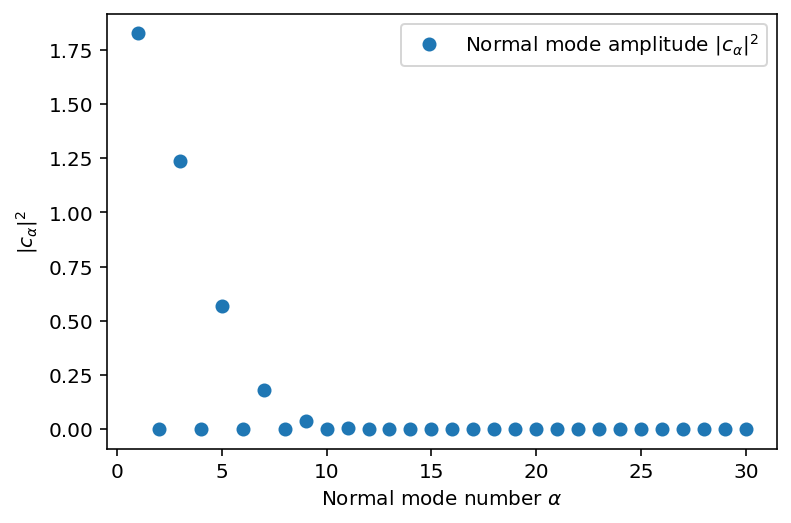

In [10]:
plt.plot(range(1,N+1),abs(ch.cs)**2,"o",label=r"Normal mode amplitude $|c_\alpha|^2$")
plt.legend()
plt.xlabel(r"Normal mode number $\alpha$")
plt.ylabel(r"$|c_\alpha|^2$");

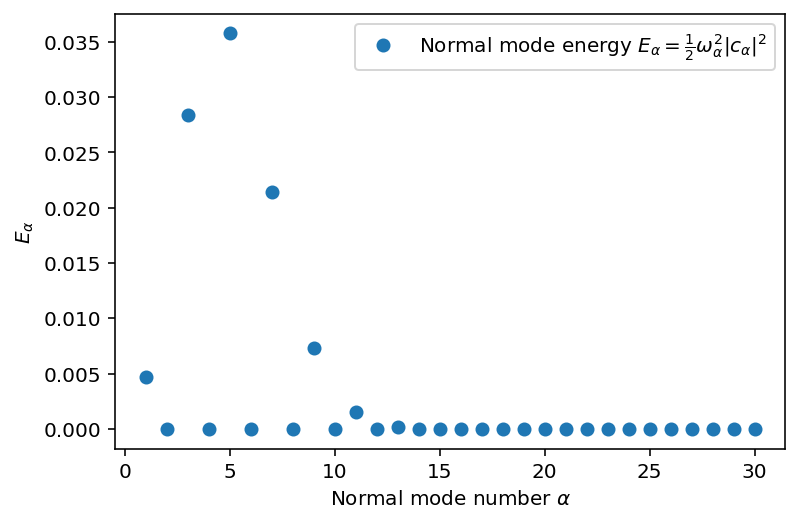

In [11]:
plt.plot(range(1,N+1),0.5*ch.ωs**2*abs(ch.cs)**2,"o",
         label=r"Normal mode energy $E_\alpha = \frac{1}{2} \omega_\alpha^2 |c_\alpha|^2$")
plt.legend()
plt.xlabel(r"Normal mode number $\alpha$")
plt.ylabel(r"$E_\alpha$");

In [12]:
%matplotlib widget
takeinds, = np.where(abs(ch.cs)>0.04)

fig, axs = plt.subplots(2,(len(takeinds)+1)//2,figsize=(13,6),sharex=True,sharey="row")
lns = []
normal_modes = []
for (ii,ax) in zip(takeinds,axs.flat):
    nm = np.real(ch.cs[ii] * ch.As[None,:,ii] * np.exp(-1j*ch.ωs[ii]*t[:,None]))
    normal_modes.append(nm)
    ln, = ax.plot(range(N), nm[0], "ko")
    ll  = ax.vlines(range(N), 0, nm[0], lw=1)
    ax.axhline(0,lw=0.5,color="0.5")
    ax.set_ylim(-0.5,0.5)
    ax.axis("off")
    ax.set_title(fr"Normal mode $\alpha={ii+1}$")
    lns.append((ln,ll))
fig.tight_layout(pad=1)

def set_data(it=0):
    for ((ln,ll),nm) in zip(lns,normal_modes):
        ln.set_ydata(nm[it])
        update_segs(ll,nm[it])
w = ipw.interactive(set_data,it=(0,len(t)-1))
play = ipw.Play(value=0,min=0,max=len(t)-1,step=1,interval=30)
ipw.jslink((play, 'value'), (w.children[0], 'value'))
ipw.HBox([play, w])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
%matplotlib inline

## Oscillator coupled to a "bath"

We here treat a "main" oscillator ($q_0$) coupled to a "continuous bath" of oscillators with frequencies distributed over a wide range, i.e.,
\begin{gather}
\ddot q_0 + \omega_1^2 q_0 + \sum_{j=1}^N g_j q_j = 0\\
\ddot q_j + \omega_j^2 q_j + g_j q_0 = 0
\end{gather}
where $\omega_j = j \Delta\omega$ for $j=1,\ldots,N$, and  $g_j = \sqrt{\frac{2\kappa \omega_j}{\pi \omega_1}}$.

In [14]:
ω1 = 1.
T = 2*np.pi / ω1
κ = 1/(20*T) # decay over 20 oscillation cycles

Ns = (100, 300, 500)
ts = np.linspace(0.,300*T,6001)
chΔωs = []
for N in Ns:
    M = np.eye(N+1)
    K = np.zeros((N+1,N+1))
    K[0,0] = M[0,0]*ω1**2
    ωbs, Δω = np.linspace(0,2*ω1,N+1,retstep=True)
    ωbs = ωbs[1:]
    for i,ω in enumerate(ωbs,start=1):
        # k = m ω^2/2
        K[i,i] = M[i,i]*ω**2
        K[0,i] = K[i,0] = np.sqrt(2*κ*Δω/np.pi*ω/ω1)

    ch = coupled_harmosc(M,K)

    q0 = np.zeros(N+1); q0[0] = 1.
    v0 = np.zeros(N+1)
    ch.solve(q0,v0,ts)
    
    chΔωs.append((ch,Δω))

The oscillation can be described (approximately) by the **complex** frequency $\omega_{\mathrm{eff}} = \omega_1 - \frac{i}{2} \kappa$ (corresponding to oscillation with frequency $\omega_1$ and decay of the amplitude with rate $\kappa/2$ (energy is quadratic in amplitude and thus decays with rate $\kappa$).

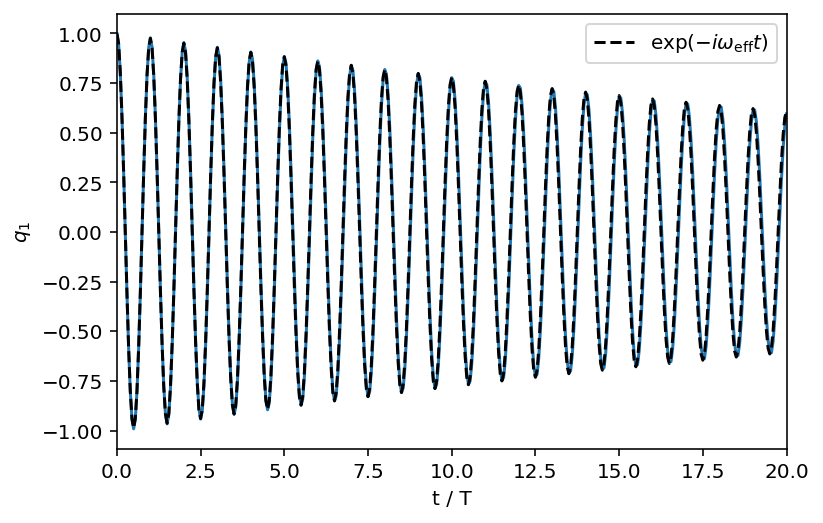

In [15]:
plt.plot(ch.t/T,ch.q[0,:]);
ωeff = ω1-0.5j*κ
plt.plot(ch.t/T,np.exp(-1j*ωeff*ch.t).real,'k--',label=r"$\exp(-i \omega_\mathrm{eff} t)$");
plt.xlabel("t / T")
plt.ylabel("$q_1$")
plt.legend();
plt.xlim(0,20);

The "discretization" of the bath with different numbers of modes $N$ leads to recurrence, i.e., energy coming back to the "main" oscillator. The recurrence happens at time $1/\Delta\omega$ (with $\Delta\omega$ the energy spacing between bath modes). For a continuous bath ($N\to\infty$, $\Delta\omega\to0$), it goes to infinity.

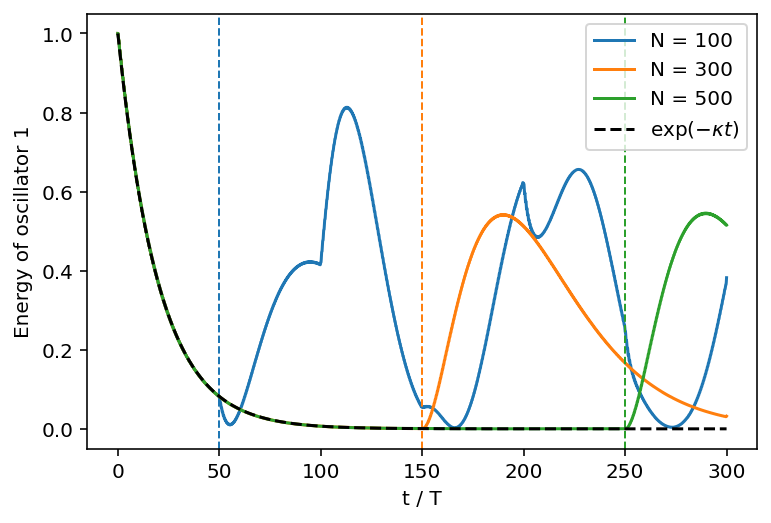

In [16]:
for N,(ch,Δω) in zip(Ns,chΔωs):
    l, = plt.plot(ch.t/T,ω1**2*ch.q[0,:]**2 + ch.v[0,:]**2,label=f"N = {N}");
    plt.axvline(1/Δω,color=l.get_color(),lw=1,ls='--')
plt.plot(ch.t/T,np.exp(-κ*ch.t),"k--",label=r"$\exp(-\kappa t)$")
plt.xlabel("t / T")
plt.ylabel("Energy of oscillator 1")
plt.legend();